In [1]:
import pandas as pd

# Load the CSV file
data = pd.read_csv("preprocessed_dataset.csv")

# Display the first few rows to confirm
print(data.head())


         asin                                        product_url  \
0  B083X4QH2Y  https://www.amazon.in/ONLY-Casual-Sweater-_571...   
1  B07GWJ9Z1F  https://www.amazon.in/001-Girls-Shopping-Sleev...   
2  B07HY6DQNT  https://www.amazon.in/0Month-Girls-Ankle-Lengt...   
3  B07NNQXF4G  https://www.amazon.in/0Month-Newborn-Booty-Mit...   
4  B00KGE3RR8  https://www.amazon.in/Hold-ups%C3%82%C2%AE-X-b...   

                                        product_name  sales_price  rating  \
0                                                NaN        874.0     3.3   
1        001 girl shop sleeveless denim jacket women        633.0     5.0   
2  0month boy girl ankl length lycra white solid ...        225.0     2.9   
3  0month newborn babi cap booti mitten set multi...        599.0     4.6   
4  1 12 wide java brown holdup xback patent nosli...        590.0     4.4   

                                       meta_keywords  \
0                                          ONLY,ONLY   
1  001 Girls Sho

In [2]:

# Step 1: Combine relevant text columns for analysis
# Fill missing values with empty strings to avoid errors
data['product_name'] = data['product_name'].fillna("")
data['meta_keywords'] = data['meta_keywords'].fillna("")
data['combined_text'] = data['product_name'] + " " + data['meta_keywords']


In [5]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from IPython.display import Image, display
import numpy as np

# Step 1: Ensure all product names are strings and handle missing values
data['product_name'] = data['product_name'].astype(str).fillna('')

# Step 2: Prepare data for Word2Vec
data['tokenized_product_name'] = data['product_name'].apply(lambda x: x.split())

# Step 3: Train the Word2Vec model
word2vec_model = Word2Vec(
    sentences=data['tokenized_product_name'], 
    vector_size=100, 
    window=5, 
    min_count=1, 
    sg=0, 
    workers=4
)

# Step 4: Create embeddings for product names
def get_product_embedding(product_name):
    tokens = product_name.split()
    vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

data['embedding'] = data['product_name'].apply(get_product_embedding)

# Step 5: Function to recommend products
def recommend_products_by_id_with_word2vec(product_id, num_recommendations=5):
    # Find the index of the product based on the product_id (asin)
    product_index = data[data['asin'] == product_id].index
    
    if len(product_index) == 0:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return
    
    product_index = product_index[0]
    target_embedding = data.iloc[product_index]['embedding']
    
    # Compute cosine similarities
    similarities = data['embedding'].apply(lambda x: cosine_similarity([target_embedding], [x])[0][0])
    
    # Sort products based on similarity scores
    similar_indices = similarities.sort_values(ascending=False).index[1:num_recommendations + 1]
    recommendations = data.iloc[similar_indices]
    
    # Display recommendations with images
    print(f"Recommendations for Product ID '{product_id}':")
    for _, row in recommendations.iterrows():
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example usage
recommend_products_by_id_with_word2vec("B07GWJ9Z1F", num_recommendations=4)


ModuleNotFoundError: No module named 'gensim'

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from IPython.display import Image, display

# Step 1: Create TF-IDF and BoW matrices
tfidf_vectorizer = TfidfVectorizer()
bow_vectorizer = CountVectorizer()

# Fit and transform the product names
tfidf_matrix = tfidf_vectorizer.fit_transform(data['product_name'])
bow_matrix = bow_vectorizer.fit_transform(data['product_name'])

# Step 2: Recommendation function combining TF-IDF and BoW
def recommend_products_combined(product_id, num_recommendations=5):
    
    # Step 2.1: Find the index of the product based on the product_id (asin)
    product_index = data[data['asin'] == product_id].index
    
    if len(product_index) == 0:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return
    
    product_index = product_index[0]
    
    # Step 2.2: Compute cosine similarities for both TF-IDF and BoW
    tfidf_similarities = cosine_similarity(tfidf_matrix[product_index], tfidf_matrix).flatten()
    bow_similarities = cosine_similarity(bow_matrix[product_index], bow_matrix).flatten()
    
    # Step 2.3: Combine the similarity scores (average of both methods)
    combined_similarities = (tfidf_similarities + bow_similarities) / 2
    
    # Step 2.4: Sort products based on combined similarity scores
    similar_indices = combined_similarities.argsort()[::-1][1:num_recommendations + 1]
    recommendations = data.iloc[similar_indices]
    
    # Step 2.5: Display recommendations with images
    print(f"\nRecommendations for Product ID '{product_id}':")
    for _, row in recommendations.iterrows():
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example usage
recommend_products_combined(product_id="B07TYLN6Q2", num_recommendations=3)




Recommendations for Product ID 'B07TYLN6Q2':
Product Name: 1 stop fashion georgett sare blous piec
Price: 349.0
Rating: 3.5


--------------------------------------------------
Product Name: mansvi fashion women s georgett sare blous piec pink blue
Price: 1110.0
Rating: 3.0


--------------------------------------------------
Product Name: anand sare georgett blous piec sare 1497 multicolour one size
Price: 299.0
Rating: 3.7


--------------------------------------------------


In [7]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image, display

# Step 1: Prepare the Data

data['product_name'] = data['product_name'].astype(str).fillna('')

# Step 2: Train Word2Vec Model
data['tokenized_product_name'] = data['product_name'].apply(lambda x: x.split())
word2vec_model = Word2Vec(
    sentences=data['tokenized_product_name'],
    vector_size=100,
    window=5,
    min_count=1,
    sg=0,  # CBOW model
    workers=4
)

# Generate embeddings for each product
def get_product_embedding(product_name):
    tokens = product_name.split()
    vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

data['embedding'] = data['product_name'].apply(get_product_embedding)

# Step 3: Create TF-IDF Matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['product_name'])

# Step 4: Recommendation Function
def recommend_products_word2vec_tfidf(product_id, num_recommendations=5):
    # Locate the target product using its ID
    product_index = data[data['asin'] == product_id].index
    
    if len(product_index) == 0:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return
    
    product_index = product_index[0]
    
    # Retrieve Word2Vec embedding and TF-IDF vector for the target product
    target_embedding = data.iloc[product_index]['embedding']
    target_vector_tfidf = tfidf_matrix[product_index]
    
    # Compute Word2Vec cosine similarity
    word2vec_similarities = data['embedding'].apply(
        lambda x: cosine_similarity([target_embedding], [x])[0][0]
    )
    
    # Compute TF-IDF cosine similarity
    tfidf_similarities = cosine_similarity(target_vector_tfidf, tfidf_matrix).flatten()
    
    # Combine the similarity scores (average of Word2Vec and TF-IDF)
    combined_similarities = (word2vec_similarities + tfidf_similarities) / 2
    
    # Sort products by combined similarity scores
    similar_indices = np.argsort(combined_similarities)[::-1][1:num_recommendations + 1]
    recommendations = data.iloc[similar_indices]
    
    # Display recommendations
    print(f"\nRecommendations for Product ID '{product_id}':")
    for _, row in recommendations.iterrows():
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example Usage
recommend_products_word2vec_tfidf(product_id="B07TYLN6Q2", num_recommendations=3)



Recommendations for Product ID 'B07TYLN6Q2':
Product Name: 1 stop fashion georgett sare blous piec
Price: 349.0
Rating: 3.5


--------------------------------------------------
Product Name: anand sare georgett blous piec sare 1497 multicolour one size
Price: 299.0
Rating: 3.7


--------------------------------------------------
Product Name: anand sare georgett blous piec sare 1499 multicolour one size
Price: 299.0
Rating: 3.9


--------------------------------------------------


In [8]:
from IPython.display import Image, display

# Function for brand-based recommendations
def recommend_products_by_brand(product_id, num_recommendations=5):
   
    # Step 1: Find the brand of the specified product
    product_row = data[data['asin'] == product_id]
    
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return
    
    product_brand = product_row.iloc[0]['brand']
    
    if not product_brand or product_brand == "Unknown":
        print(f"No brand information found for product ID '{product_id}'.")
        return
    
    print(f"Recommendations for products from the brand '{product_brand}':\n")
    
    # Step 2: Filter products from the same brand (excluding the current product)
    brand_products = data[(data['brand'] == product_brand) & (data['asin'] != product_id)]
    
    if brand_products.empty:
        print(f"No other products found for the brand '{product_brand}'.")
        return
    
    # Step 3: Limit the number of recommendations
    recommendations = brand_products.head(num_recommendations)
    
    # Step 4: Display recommendations
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example usage
recommend_products_by_brand(product_id="B07YX2JKGQ", num_recommendations=3)


Recommendations for products from the brand 'Max':

Product ID: B07YX2MFL1
Product Name: max babi girl s tshirt
Price: 183.0
Rating: 4.5


--------------------------------------------------
Product ID: B07VK1VSPS
Product Name: max babyboy knitwear
Price: 295.0
Rating: 3.0


--------------------------------------------------
Product ID: B07XNLNDM8
Product Name: max babyboy knitwear
Price: 359.0
Rating: 4.0


--------------------------------------------------


In [9]:


# Train Word2Vec Model
def train_word2vec_model(data):
    # Tokenize the product names
    tokenized_product_names = data['product_name'].apply(lambda x: x.split())
    
    # Train Word2Vec model
    word2vec_model = Word2Vec(sentences=tokenized_product_names, vector_size=150, window=10, min_count=1, sg=0, workers=4)
    return word2vec_model

# Get average word embedding for a product name
def get_word2vec_embedding(word2vec_model, product_name):
    tokens = product_name.split()
    vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Recommendation function with TF-IDF and Word2Vec (Weighted combination + Ranking)
def recommend_products_by_brand_with_improved_similarity(product_id, num_recommendations=5, tfidf_weight=0.5, word2vec_weight=0.5):
    product_row = data[data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return

    product_brand = product_row.iloc[0]['brand']
    if not product_brand or product_brand == "Unknown":
        print(f"No brand information found for product ID '{product_id}'.")
        return

    target_product_name = product_row.iloc[0]['product_name']
    print(f"Recommendations for products from the brand '{product_brand}':\n")

    # Filter products from the same brand
    brand_products = data[(data['brand'] == product_brand) & (data['asin'] != product_id)]
    if brand_products.empty:
        print(f"No other products found for the brand '{product_brand}'.")
        return

    # Step 1: TF-IDF similarity
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(brand_products['product_name'])
    target_vector = tfidf_vectorizer.transform([target_product_name])
    tfidf_similarities = cosine_similarity(target_vector, tfidf_matrix).flatten()

    # Step 2: Word2Vec similarity
    word2vec_model = train_word2vec_model(data)
    target_word2vec_embedding = get_word2vec_embedding(word2vec_model, target_product_name)
    
    # Get Word2Vec embeddings for all brand products
    brand_product_embeddings = np.array([get_word2vec_embedding(word2vec_model, name) for name in brand_products['product_name']])
    
    # Calculate cosine similarity between target product and each product's Word2Vec embedding
    word2vec_similarities = cosine_similarity([target_word2vec_embedding], brand_product_embeddings).flatten()

    # Step 3: Combine TF-IDF and Word2Vec similarities (with weights)
    combined_similarities = (tfidf_weight * tfidf_similarities + word2vec_weight * word2vec_similarities)

    # Step 4: Rank recommendations by combined similarity score and price
    brand_products['combined_similarity'] = combined_similarities
    recommendations = brand_products.sort_values(by=['combined_similarity', 'sales_price'], ascending=[False, True]).head(num_recommendations)

    # Display recommendations
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print(f"Product Name: {row['brand']}")
        print("-" * 50)

# Example usage
recommend_products_by_brand_with_improved_similarity(product_id="B07YX2JKGQ", num_recommendations=3)


Recommendations for products from the brand 'Max':

Product ID: B07YX2MFL1
Product Name: max babi girl s tshirt
Price: 183.0
Rating: 4.5


C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_7024\1994006042.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_products['combined_similarity'] = combined_similarities


Product Name: Max
--------------------------------------------------
Product ID: B07YX1K36W
Product Name: max boy s tshirt
Price: 199.0
Rating: 4.1


Product Name: Max
--------------------------------------------------
Product ID: B07YWZXL7N
Product Name: max boy s tshirt
Price: 229.0
Rating: 4.4


Product Name: Max
--------------------------------------------------


In [7]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install keras==3.5.0

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
    --------------------------------------- 0.0/1.1 MB 330.3 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.1 MB 919.0 kB/s eta 0:00:02
   ----------------- ---------------------- 0.5/1.1 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image as PILImage
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image, display
import requests
from io import BytesIO

# Load pre-trained VGG16 model without the top classification layer
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess and extract features from an image URL
def extract_image_features_vgg(image_url):
    try:
        # Load image from URL
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize image to match model input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten()
    except Exception as e:
        print(f"Error processing image from URL: {image_url}, {e}")
        return np.zeros(512)  # Return a zero vector; VGG16 outputs 512 features with `pooling='avg'`

# Extract features for all product images in the dataset
def extract_features_for_dataset_vgg(data):
    image_features = []
    for image_url in data['medium']:
        features = extract_image_features_vgg(image_url)
        image_features.append(features)
    return np.array(image_features)

# Image-based recommendation function using VGG16
def recommend_products_by_image_vgg(product_id, data, num_recommendations=5):
    product_row = data[data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return

    # Extract target product's image features
    target_image_url = product_row.iloc[0]['medium']
    target_features = extract_image_features_vgg(target_image_url)

    # Compute similarities with all other product images
    image_features = extract_features_for_dataset_vgg(data)
    similarities = cosine_similarity([target_features], image_features).flatten()

    # Add similarity scores to the dataset and rank
    data['similarity'] = similarities
    recommendations = data.sort_values(by='similarity', ascending=False).head(num_recommendations + 1)
    recommendations = recommendations[recommendations['asin'] != product_id]  # Exclude the target product

    # Display recommendations
    print(f"Image-based recommendations for product ID '{product_id}':\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example usage
recommend_products_by_image_vgg(product_id="B07GWJ9Z1F", data=data, num_recommendations=5)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━

In [3]:
import torch

In [5]:
print(torch.cuda.device_count())

1


In [13]:
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4060 Laptop GPU


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image as PILImage
import requests
from io import BytesIO
from IPython.display import Image, display

# Load pre-trained ResNet50 model without the top classification layer
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess and extract features from an image URL
def extract_image_features(image_url):
    try:
        # Load image from URL
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize image to match model input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten()
    except Exception as e:
        print(f"Error processing image from URL: {image_url}, {e}")
        return np.zeros(2048)  # Return a zero vector for invalid images

# Function to recommend products based on a product ID
def recommend_products_by_product_id(product_id, data, num_recommendations=5):
    # Get the product row for the given ID
    product_row = data[data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return

    # Extract the image URL for the given product ID
    train_image_url = product_row.iloc[0]['medium']
    print(f"Training with image from product ID: {product_id}\nURL: {train_image_url}")

    # Extract features for the training image
    trained_features = extract_image_features(train_image_url)

    # Extract features for the first 1000 images in the dataset
    image_features = []
    limited_data = data.head(1000)  # Process only the first 1000 rows
    for image_url in limited_data['medium']:
        features = extract_image_features(image_url)
        image_features.append(features)
    image_features = np.array(image_features)

    # Compute cosine similarity with the trained image features
    similarities = cosine_similarity([trained_features], image_features).flatten()

    # Add similarity scores to the dataset and rank
    limited_data['similarity'] = similarities
    recommendations = limited_data.sort_values(by='similarity', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example usage
# Pass the `data` DataFrame and a `product_id` to the function
recommend_products_by_product_id(product_id="B07TYLN6Q2", data=data, num_recommendations=5)


Training with image from product ID: B07TYLN6Q2
URL: https://images-na.ssl-images-amazon.com/images/I/41r6yqUFEoL.jpg
1/1 [==============================] - 0s 127ms/step
Error processing image from URL: https://images-na.ssl-images-amazon.com/images/I/412uawB90lL.jpg|https://images-na.ssl-images-amazon.com/images/I/41IDpX8HPtL.jpg|https://images-na.ssl-images-amazon.com/images/I/513teYuhO6L.jpg|https://images-na.ssl-images-amazon.com/images/I/41gaWmDBckL.jpg, cannot identify image file <_io.BytesIO object at 0x00000209A0BFA680>
1/1 [==============================] - 0s 125ms/step
Error processing image from URL: https://images-na.ssl-images-amazon.com/images/I/31B%2BLVT3IbL.jpg|https://images-na.ssl-images-amazon.com/images/I/31Sn2NMFUdL.jpg|https://images-na.ssl-images-amazon.com/images/I/41VtGDiYz5L.jpg|https://images-na.ssl-images-amazon.com/images/I/31EhzuogQzL.jpg|https://images-na.ssl-images-amazon.com/images/I/31lAFEq6J2L.jpg|https://images-na.ssl-images-amazon.com/images/I/31U

C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_31884\2300369723.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_data['similarity'] = similarities


--------------------------------------------------
Product ID: B07MG59XDS
Product Name: aai shree khodiyar art georgett sare
Price: 545.0
Rating: 3.6


--------------------------------------------------
Product ID: B07M9YQXBZ
Product Name: aalia art silk blous piec sare
Price: 689.0
Rating: 4.6


--------------------------------------------------
Product ID: B07HTZCDYS
Product Name: 1 stop fashion georgett sare blous piec
Price: 349.0
Rating: 3.5


--------------------------------------------------
Product ID: B07BJKQ68Y
Product Name: aaradhya fashion women s bhagalpuri kalamkari instrument sare blous piec
Price: 449.0
Rating: 4.0


--------------------------------------------------


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from PIL import Image as PILImage
import requests
from io import BytesIO
from IPython.display import Image, display

# Load pre-trained MobileNet model without the top classification layer
model = MobileNet(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess and extract features from an image URL
def extract_image_features(image_url):
    try:
        # Load image from URL
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize image to match model input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten()
    except Exception as e:
        print(f"Error processing image from URL: {image_url}, {e}")
        return np.zeros(1024)  # Return a zero vector for invalid images

# Function to recommend products based on a product ID
def recommend_products_by_product_id(product_id, train_data, test_data, num_recommendations=5):
    # Get the product row for the given ID
    product_row = train_data[train_data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the training dataset.")
        return

    # Extract the image URL for the given product ID
    train_image_url = product_row.iloc[0]['medium']
    print(f"Training with image from product ID: {product_id}\nURL: {train_image_url}")

    # Extract features for the training image
    trained_features = extract_image_features(train_image_url)

    # Extract features for all images in the test dataset
    image_features = []
    for image_url in test_data['medium']:
        features = extract_image_features(image_url)
        image_features.append(features)
    image_features = np.array(image_features)

    # Compute cosine similarity with the trained image features
    similarities = cosine_similarity([trained_features], image_features).flatten()

    # Add similarity scores to the test dataset and rank
    test_data['similarity'] = similarities
    recommendations = test_data.sort_values(by='similarity', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

    return recommendations

# Function to calculate recommendation accuracy
def calculate_accuracy(recommendations, test_data, relevance_threshold=4.0):
    """
    Calculates precision and recall.
    - `recommendations`: The top-N recommendations returned by the model.
    - `test_data`: The test data with actual relevance scores.
    - `relevance_threshold`: The rating threshold to consider a product as relevant.
    """
    # Mark products as relevant (1) or not relevant (0) based on ratings
    test_data['is_relevant'] = test_data['rating'] >= relevance_threshold

    # Check the relevance of recommended products
    recommended_ids = recommendations['asin'].tolist()
    relevant_ids = test_data[test_data['is_relevant']]['asin'].tolist()
    
    y_true = [1 if asin in relevant_ids else 0 for asin in recommended_ids]
    y_pred = [1] * len(recommended_ids)  # All recommended items are considered relevant

    # Compute precision and recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    return precision, recall

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data.head(1000), test_size=0.2, random_state=42)

# Example usage
# Pass the `train_data` and `test_data` DataFrames and a `product_id` to the function
product_id = "B07TYLN6Q2"
recommendations = recommend_products_by_product_id(product_id=product_id, train_data=train_data, test_data=test_data, num_recommendations=5)

# Calculate accuracy
calculate_accuracy(recommendations, test_data, relevance_threshold=4.0)


C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_19220\2161777746.py:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(weights='imagenet', include_top=False, pooling='avg')


Training with image from product ID: B07TYLN6Q2
URL: https://images-na.ssl-images-amazon.com/images/I/41r6yqUFEoL.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━

--------------------------------------------------
Product ID: B083QLJZYD
Product Name: ahalyaa women s polysilk front slit kurti light pink
Price: 940.0
Rating: 4.0


--------------------------------------------------
Product ID: B07414KBJN
Product Name: ajil pantaloon women s flare tshirt
Price: 366.0
Rating: 2.9


--------------------------------------------------
Product ID: B07S4774MK
Product Name: aayan export women s silk embroid semistitch lehenga choli dupatta set blue free size
Price: 480.0
Rating: 3.6


--------------------------------------------------
Product ID: B07GC2Q59G
Product Name: 109 f women blend polyest blue stripe dress
Price: 719.0
Rating: 5.0


--------------------------------------------------
Precision: 0.40
Recall: 1.00


(0.4, 1.0)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from PIL import Image as PILImage
import requests
from io import BytesIO
from IPython.display import Image, display

# Load EfficientNetB0 model without the top classification layer
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess and extract features from an image URL
def extract_image_features(image_url):
    try:
        # Load image from URL
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize image to match model input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten()
    except Exception as e:
        print(f"Error processing image from URL: {image_url}, {e}")
        return np.zeros(1280)  # EfficientNetB0 outputs 1280 features

# Function to recommend products based on a product ID
def recommend_products_by_product_id(product_id, train_data, test_data, num_recommendations=5):
    # Get the product row for the given ID
    product_row = train_data[train_data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the training dataset.")
        return

    # Extract the image URL for the given product ID
    train_image_url = product_row.iloc[0]['medium']
    print(f"Training with image from product ID: {product_id}\nURL: {train_image_url}")

    # Extract features for the training image
    trained_features = extract_image_features(train_image_url)

    # Extract features for all images in the test dataset
    image_features = []
    for image_url in test_data['medium']:
        features = extract_image_features(image_url)
        image_features.append(features)
    image_features = np.array(image_features)

    # Compute cosine similarity with the trained image features
    similarities = cosine_similarity([trained_features], image_features).flatten()

    # Add similarity scores to the test dataset and rank
    test_data['similarity'] = similarities
    recommendations = test_data.sort_values(by='similarity', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

    return recommendations

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data.head(1000), test_size=0.2, random_state=42)

# Example usage
# Pass the `train_data` and `test_data` DataFrames and a `product_id` to the function
product_id = "B083QLJZYD"
recommendations = recommend_products_by_product_id(product_id=product_id, train_data=train_data, test_data=test_data, num_recommendations=5)


Product with ID 'B083QLJZYD' not found in the training dataset.


In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image as PILImage
import requests
from io import BytesIO
import pandas as pd
from tensorflow.keras.optimizers import Adam
from IPython.display import display, Image as IPImage 
# Load pre-trained VGG16 model without the top classification layer
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess and extract features from an image URL
def preprocess_image(image_url):
    try:
        # Attempt to download and process the image
        response = requests.get(image_url, timeout=10)  # Add timeout to avoid long waits
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize image to match model input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Adds an extra dimension
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error processing image URL: {image_url}. Error: {e}")
        return None  # Return None for invalid images

# Prepare the dataset (first 1000 images)
def prepare_dataset(data):
    images = []
    valid_labels = []
    for url, label in zip(data['medium'], data['product_name']):
        processed_image = preprocess_image(url)
        if processed_image is not None:
            images.append(processed_image)
            valid_labels.append(label)
    
    # Convert list of images into a batch
    images = np.vstack(images)  # Stacks images into a single numpy array
    labels = pd.Series(valid_labels).astype('category').cat.codes  # Encode product names as categories
    labels = to_categorical(labels)  # Convert to one-hot encoding
    return images, labels

# Prepare the data (use first 1000 images)
data = data.head(500)  # Assuming `data` is pre-loaded with the dataset
images, labels = prepare_dataset(data)

# Build the model with VGG16 for feature extraction and a classifier on top
model = VGG16(weights='imagenet', include_top=False, pooling='avg')
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(labels.shape[1], activation='softmax')(x)  # Number of classes

# Complete model
final_model = tf.keras.models.Model(inputs=model.input, outputs=x)

# Compile the model
final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
final_model.fit(images, labels, batch_size=32, epochs=3, validation_split=0.2)

# Function to recommend products based on a product ID
def recommend_products_by_product_id(product_id, data, num_recommendations=5):
    # Get the product row for the given ID
    product_row = data[data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return

    # Extract the image URL for the given product ID
    train_image_url = product_row.iloc[0]['medium']
    print(f"Training with image from product ID: {product_id}\nURL: {train_image_url}")

    # Extract features for the training image
    train_image = preprocess_image(train_image_url)
    if train_image is None:
        return

    # Predict the features for the trained image using the model
    trained_features = final_model.predict(train_image)

    # Extract features for the first 1000 images in the dataset
    image_features = []
    limited_data = data.head(10)  # Process only the first 1000 rows
    for image_url in limited_data['medium']:
        processed_image = preprocess_image(image_url)
        if processed_image is not None:
            features = final_model.predict(processed_image)
            image_features.append(features.flatten())
    
    image_features = np.array(image_features)

    # Compute cosine similarity with the trained image features
    similarities = cosine_similarity([trained_features.flatten()], image_features).flatten()

    # Add similarity scores to the dataset and rank
    limited_data['similarity'] = similarities
    recommendations = limited_data.sort_values(by='similarity', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        display(IPImage(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Example usage
# Pass the `data` DataFrame and a `product_id` to the function
recommend_products_by_product_id(product_id="B01DAYHAMI", data=data, num_recommendations=5)


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 14s/step - accuracy: 0.0180 - loss: 30.9208 - val_accuracy: 0.0000e+00 - val_loss: 74.3916
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 14s/step - accuracy: 0.0344 - loss: 52.8192 - val_accuracy: 0.0000e+00 - val_loss: 103.2918
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 14s/step - accuracy: 0.0422 - loss: 66.7590 - val_accuracy: 0.0000e+00 - val_loss: 4.6000
Training with image from product ID: B01DAYHAMI
URL: https://images-na.ssl-images-amazon.com/images/I/31OZHFOmt1L.jpg|https://images-na.ssl-images-amazon.com/images/I/51EcwhoVyFL.jpg|https://images-na.ssl-images-amazon.com/images/I/41vURk%2BKzOL.jpg|https://images-na.ssl-images-amazon.com/images/I/41yYsgP0cUL.jpg|https://images-na.ssl-images-amazon.com/images/I/41xowcovk0L.jpg|https://images-na.ssl-images-amazon.com/images/I/51lDWshLGfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51onxNbYYfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51cml7%2BmzSL.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms

C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_22372\2100277356.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_data['similarity'] = similarities


--------------------------------------------------
Product ID: B07GWJ9Z1F
Product Name: 001 girl shop sleeveless denim jacket women
Price: 633.0
Rating: 5.0


--------------------------------------------------
Product ID: B083X4QH2Y
Product Name: 
Price: 874.0
Rating: 3.3


--------------------------------------------------
Product ID: B083QR418Y
Product Name: 1 stop fashion crepe shirt dress
Price: 175.0
Rating: 2.8


--------------------------------------------------
Product ID: B07TYLN6Q2
Product Name: 1 stop fashion georgett blous piec sare 815ct pink beig one size
Price: 612.0
Rating: 4.4


--------------------------------------------------


In [13]:
"""import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from PIL import Image as PILImage
import requests
from io import BytesIO
from IPython.display import Image, display

# Load the pre-trained MobileNet model and add additional layers
base_model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Add custom layers
x = Dense(512, activation='relu')(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1024, activation='linear')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Function to preprocess and extract features from an image URL
def extract_image_features(image_url):
    try:
        # Load image from URL
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize image to match model input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten()
    except Exception as e:
        print(f"Error processing image from URL: {image_url}, {e}")
        return np.zeros(1024)  # Return a zero vector for invalid images

# Function to recommend products based on a product ID
def recommend_products_by_product_id(product_id, train_data, test_data, num_recommendations=5, rating_weight=0.3):
    """
    Recommends products based on a product ID by combining visual similarity and ratings.
    - `rating_weight`: Determines the importance of ratings in the ranking (0-1).
    """
    # Get the product row for the given ID
    product_row = train_data[train_data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the training dataset.")
        return

    # Extract the image URL for the given product ID
    train_image_url = product_row.iloc[0]['medium']
    print(f"Training with image from product ID: {product_id}\nURL: {train_image_url}")

    # Extract features for the training image
    trained_features = extract_image_features(train_image_url)

    # Filter out low-rated products in the test dataset
    filtered_test_data = test_data[test_data['rating'] >= 3.5]
    if filtered_test_data.empty:
        print("No products with a rating above the threshold in the test dataset.")
        return

    # Extract features for all images in the filtered test dataset
    image_features = []
    for image_url in filtered_test_data['medium']:
        features = extract_image_features(image_url)
        image_features.append(features)
    image_features = np.array(image_features)

    # Compute cosine similarity with the trained image features
    similarities = cosine_similarity([trained_features], image_features).flatten()

    # Normalize ratings to the range [0, 1]
    max_rating = test_data['rating'].max()
    min_rating = test_data['rating'].min()
    filtered_test_data['normalized_rating'] = (filtered_test_data['rating'] - min_rating) / (max_rating - min_rating)

    # Combine similarity and ratings for ranking
    filtered_test_data['similarity'] = similarities
    filtered_test_data['combined_score'] = (
        (1 - rating_weight) * filtered_test_data['similarity'] +
        rating_weight * filtered_test_data['normalized_rating']
    )

    # Rank recommendations by the combined score
    recommendations = filtered_test_data.sort_values(by='combined_score', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image and ratings:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        print(f"Combined Score: {row['combined_score']:.2f}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

    return recommendations

# Train-test split
train_data, test_data = train_test_split(data.head(1000), test_size=0.2, random_state=42)

# Example usage
product_id = "B07TYLN6Q2"  # Replace with a valid product ID
recommendations = recommend_products_by_product_id(
    product_id=product_id,
    train_data=train_data,
    test_data=test_data,
    num_recommendations=5,
    rating_weight=0.3  # Adjust weight to prioritize ratings
)"""


Training with image from product ID: B07TYLN6Q2
URL: https://images-na.ssl-images-amazon.com/images/I/41r6yqUFEoL.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/s

C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_14472\2979377193.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['normalized_rating'] = (filtered_test_data['rating'] - min_rating) / (max_rating - min_rating)
C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_14472\2979377193.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['similarity'] = similarities
C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_14472\2979377193.py:93: SettingWithCopyWarning: 
A val

--------------------------------------------------
Product ID: B07NTDW72M
Product Name: aasi hous nayo cotton alin dress
Price: 923.0
Rating: 5.0
Combined Score: 0.88


--------------------------------------------------
Product ID: B07GC2Q59G
Product Name: 109 f women blend polyest blue stripe dress
Price: 719.0
Rating: 5.0
Combined Score: 0.88


--------------------------------------------------
Product ID: B07Y87JY5Y
Product Name: aj creation plain solid rayon alin kurti women s
Price: 499.0
Rating: 5.0
Combined Score: 0.88


--------------------------------------------------
Product ID: B07XY125D8
Product Name: ahura fashion women s print unstitch churidar suit dress materialfre size
Price: 750.0
Rating: 5.0
Combined Score: 0.88


--------------------------------------------------


In [66]:
from sklearn.metrics import accuracy_score, recall_score

def evaluate_recommendations(recommended_products, threshold=3.5):
    """
    Evaluates the accuracy and recall of the recommendations based on the given threshold rating.
    """
    # Ground truth: Products with a rating above the threshold
    ground_truth = recommended_products['rating'] >= threshold

    # Predictions: Products that are recommended
    predictions = recommended_products['rating'] >= threshold

    # Accuracy and Recall calculation
    accuracy = accuracy_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    return accuracy, recall

def recommend_products_by_product_id(product_id, train_data, test_data, num_recommendations=5, rating_weight=0.3):
    """
    Recommends products based on a product ID by combining visual similarity and ratings.
    """
    # Get the product row for the given ID
    product_row = train_data[train_data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the training dataset.")
        return

    # Extract the image URL for the given product ID
    train_image_url = product_row.iloc[0]['medium']
    print(f"Training with image from product ID: {product_id}\nURL: {train_image_url}")

    # Extract features for the training image
    trained_features = extract_image_features(train_image_url)

    # Filter out low-rated products in the test dataset
    filtered_test_data = test_data[test_data['rating'] >= 3.5]
    if filtered_test_data.empty:
        print("No products with a rating above the threshold in the test dataset.")
        return

    # Extract features for all images in the filtered test dataset
    image_features = []
    for image_url in filtered_test_data['medium']:
        features = extract_image_features(image_url)
        image_features.append(features)
    image_features = np.array(image_features)

    # Compute cosine similarity with the trained image features
    similarities = cosine_similarity([trained_features], image_features).flatten()

    # Normalize ratings to the range [0, 1]
    max_rating = test_data['rating'].max()
    min_rating = test_data['rating'].min()
    filtered_test_data['normalized_rating'] = (filtered_test_data['rating'] - min_rating) / (max_rating - min_rating)

    # Combine similarity and ratings for ranking
    filtered_test_data['similarity'] = similarities
    filtered_test_data['combined_score'] = (
        (1 - rating_weight) * filtered_test_data['similarity'] +
        rating_weight * filtered_test_data['normalized_rating']
    )

    # Rank recommendations by the combined score
    recommendations = filtered_test_data.sort_values(by='combined_score', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image and ratings:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        print(f"Combined Score: {row['combined_score']:.2f}")
        display(Image(url=row['medium'], width=200, height=200))
        print("-" * 50)

    # Evaluate the accuracy and recall of the recommendations
    evaluate_recommendations(recommendations)
    
    return recommendations

# Train-test split
train_data, test_data = train_test_split(data.head(1000), test_size=0.2, random_state=42)

# Example usage
product_id = "B01DAYHAMI"  # Replace with a valid product ID
recommendations = recommend_products_by_product_id(
    product_id=product_id,
    train_data=train_data,
    test_data=test_data,
    num_recommendations=4,
    rating_weight=0.3  # Adjust weight to prioritize ratings
)


Training with image from product ID: B01DAYHAMI
URL: https://images-na.ssl-images-amazon.com/images/I/31OZHFOmt1L.jpg|https://images-na.ssl-images-amazon.com/images/I/51EcwhoVyFL.jpg|https://images-na.ssl-images-amazon.com/images/I/41vURk%2BKzOL.jpg|https://images-na.ssl-images-amazon.com/images/I/41yYsgP0cUL.jpg|https://images-na.ssl-images-amazon.com/images/I/41xowcovk0L.jpg|https://images-na.ssl-images-amazon.com/images/I/51lDWshLGfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51onxNbYYfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51cml7%2BmzSL.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms

C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_14472\3850628043.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['normalized_rating'] = (filtered_test_data['rating'] - min_rating) / (max_rating - min_rating)
C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_14472\3850628043.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['similarity'] = similarities
C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_14472\3850628043.py:61: SettingWithCopyWarning: 
A val

--------------------------------------------------
Product ID: B013HL6FL6
Product Name: 100 silk extra long tie diamond weav pattern avail 63 xl 70 xxl
Price: 590.0
Rating: 4.5
Combined Score: 0.70


--------------------------------------------------
Product ID: B076HX4RD9
Product Name: aeht men s synthet neckti
Price: 249.0
Rating: 5.0
Combined Score: 0.57


--------------------------------------------------
Product ID: B013D7PJMA
Product Name: 100 silk solid tie avail 63 xl 70 xxl
Price: 590.0
Rating: 4.5
Combined Score: 0.56


--------------------------------------------------
Accuracy: 1.00
Recall: 1.00


In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image as PILImage
import requests
from io import BytesIO
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, Image as IPImage  # Correct import for Jupyter

# Load the MobileNet model
base_model = MobileNet(weights="imagenet", include_top=False, pooling='avg')

# Function to preprocess and extract features from an image URL
def preprocess_image(image_url):
    try:
        response = requests.get(image_url, timeout=10)  # Timeout to avoid long waits
        img = PILImage.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))  # Resize to match model input
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error processing image URL: {image_url}. Error: {e}")
        return None

# Prepare the dataset (process images and labels)
def prepare_dataset(data):
    images, valid_labels = [], []
    for url, label in zip(data['medium'], data['product_name']):
        processed_image = preprocess_image(url)
        if processed_image is not None:
            images.append(processed_image)
            valid_labels.append(label)
    images = np.vstack(images)  # Stack into a numpy array
    labels = pd.Series(valid_labels).astype('category').cat.codes  # Encode categories
    labels = to_categorical(labels)  # Convert to one-hot encoding
    return images, labels

# Define the final model with MobileNet as the base
def build_model(num_classes):
    x = base_model.output
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=x)

# Recommendation function
def recommend_products_by_product_id(product_id, train_data, test_data, num_recommendations=5, rating_weight=0.3):
    # Get the product row for the given ID
    product_row = train_data[train_data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the training dataset.")
        return

    train_image_url = product_row.iloc[0]['medium']
    train_image = preprocess_image(train_image_url)
    if train_image is None:
        print("Failed to process the training image.")
        return

    trained_features = model.predict(train_image)

    # Filter out low-rated products
    filtered_test_data = test_data[test_data['rating'] >= 3.5]
    if filtered_test_data.empty:
        print("No products with a rating above the threshold in the test dataset.")
        return

    # Extract features for all images in the filtered test dataset
    image_features = []
    for image_url in filtered_test_data['medium']:
        processed_image = preprocess_image(image_url)
        if processed_image is not None:
            features = model.predict(processed_image)
            image_features.append(features.flatten())
    image_features = np.array(image_features)

    # Compute cosine similarity
    similarities = cosine_similarity([trained_features.flatten()], image_features).flatten()

    # Normalize ratings
    max_rating = test_data['rating'].max()
    min_rating = test_data['rating'].min()
    filtered_test_data['normalized_rating'] = (filtered_test_data['rating'] - min_rating) / (max_rating - min_rating)

    # Combine similarity and ratings
    filtered_test_data['similarity'] = similarities
    filtered_test_data['combined_score'] = (
        (1 - rating_weight) * filtered_test_data['similarity'] +
        rating_weight * filtered_test_data['normalized_rating']
    )

    # Rank recommendations
    recommendations = filtered_test_data.sort_values(by='combined_score', ascending=False).head(num_recommendations)

    # Display recommendations
    print("Recommendations based on the trained image and ratings:\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        print(f"Combined Score: {row['combined_score']:.2f}")
        display(IPImage(url=row['medium'], width=200, height=200))
        print("-" * 50)

# Assume `data` is a DataFrame already loaded
# Split the data into training and testing datasets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Prepare images and labels
images, labels = prepare_dataset(train_data)

# Build and compile the model
num_classes = labels.shape[1]
model = build_model(num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(images, labels, batch_size=32, epochs=3, validation_split=0.2)

# Call the recommendation function
recommend_products_by_product_id(
    product_id="B01DAYHAMI",
    train_data=train_data,
    test_data=test_data,
    num_recommendations=5
)


C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_22372\264003484.py:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, pooling='avg')


Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0625 - loss: 4.9165 - val_accuracy: 0.0000e+00 - val_loss: 5.4525
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5938 - loss: 1.7827 - val_accuracy: 0.0000e+00 - val_loss: 6.6695
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7917 - loss: 0.8687 - val_accuracy: 0.0000e+00 - val_loss: 8.2794
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Recommendations based on the trained image and ratings:

Product ID: B013J7B5YA
Produc

C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_22372\264003484.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['normalized_rating'] = (filtered_test_data['rating'] - min_rating) / (max_rating - min_rating)
C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_22372\264003484.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['similarity'] = similarities
C:\Users\MonishDiknesh\AppData\Local\Temp\ipykernel_22372\264003484.py:96: SettingWithCopyWarning: 
A value 

--------------------------------------------------
Product ID: B015T2T9LO
Product Name: 173rd airborn brigad vietnam veteran ball cap
Price: 590.0
Rating: 5.0
Combined Score: 0.96


--------------------------------------------------
Product ID: B00JLGPP86
Product Name: 100 silk diamond pattern men s extra long tie avail 63 xl 70 xxl
Price: 590.0
Rating: 4.6
Combined Score: 0.94


--------------------------------------------------
Product ID: B00WZ9GCPQ
Product Name: 11th armor cavalri regiment basebal cap black hors 11th acr hat men
Price: 590.0
Rating: 4.7
Combined Score: 0.90


--------------------------------------------------
Product ID: B01ASWB78I
Product Name: 100 silk extra extra long tie lavend herringbon silk xxl 70inch length
Price: 590.0
Rating: 4.2
Combined Score: 0.89


--------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113

C:\Users\MonishDiknesh\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 14.1570 - mae: 3.2568 - val_loss: 3.5526 - val_mae: 1.7187
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.8781 - mae: 1.8451 - val_loss: 1.3226 - val_mae: 0.8881
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6962 - mae: 1.4756 - val_loss: 2.3243 - val_mae: 1.3630
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.9852 - mae: 1.4726 - val_loss: 1.3293 - val_mae: 0.8965
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.3125 - mae: 1.1990 - val_loss: 1.6676 - val_mae: 1.1136
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.5149 - mae: 0.9934 - val_loss: 1.0845 - val_mae: 0.8829
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3666 - mae: 0.9519 - val_loss: 1.0997 - val_mae: 0.8894
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2648 - mae: 0.9126 - val_loss: 0.8998 - val_mae: 0.7533
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1929 - mae: 0.8905 - val_loss: 

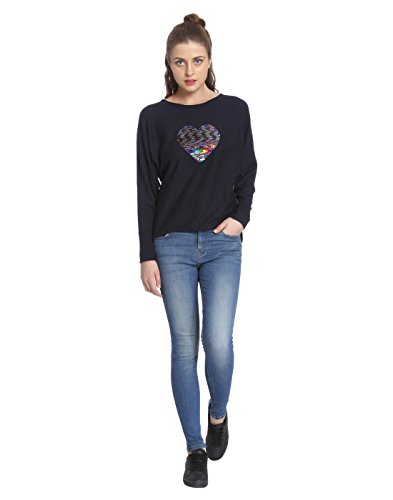

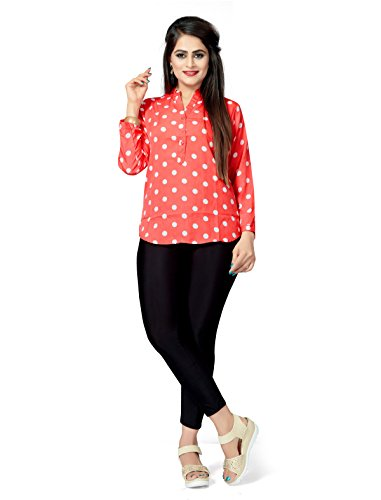

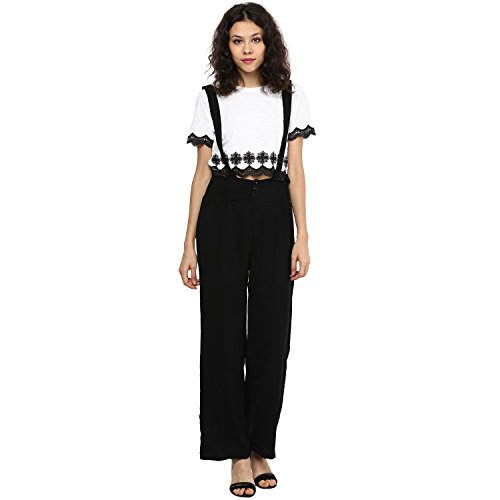

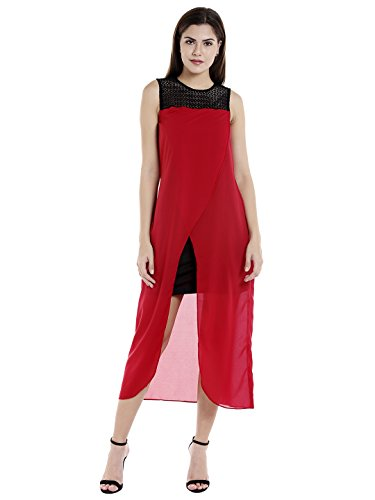


Input Product Details (ID: B083X4QH2Y):
Name: 
Rating: 3.3

Recommended Products:
Recommended 1 ID: B07NSC3QQL
Name: 1 stop fashion women s regular fit top
Rating: 3.0
----------------------------------------
Recommended 2 ID: B07FQRLQ45
Name: 109 f women black solid polyest jumpsuit without top
Rating: 3.7
----------------------------------------
Recommended 3 ID: B07FVQPKKN
Name: 109 f women polyest red solid maxi dress
Rating: 4.0
----------------------------------------

Model Accuracy:
Training MAE: 0.8275033831596375
Validation MAE: 0.8488516807556152


In [71]:
import numpy as np
import pandas as pd
import requests
from io import BytesIO
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import Image as IPImage, display


# Preprocessing function to load and resize images
def preprocess_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((224, 224))  # Resize to MobileNet input size
    img = image.img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess image for MobileNet
    return img


# Prepare the data for training by extracting features from images
def extract_features(data):
    model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.trainable = False  # Freeze the pre-trained layers

    # Global Average Pooling layer to convert feature maps to 1D
    model = models.Sequential([
        model,
        layers.GlobalAveragePooling2D()
    ])
    
    features = []
    for img_url in data['medium']:  # Assuming 'medium' contains image URLs
        img = preprocess_image(img_url)
        feature = model.predict(img)
        features.append(feature.flatten())  # Flatten the features to a 1D array
    
    return np.array(features)


# Extract features for all products
features = extract_features(data)

# Function to train the model with additional layers
def train_model(features, epochs=10):
    # Adding Dense and Dropout layers on top of MobileNetV2 features
    custom_model = models.Sequential([
        layers.InputLayer(input_shape=(features.shape[1],)),  # Input shape from the feature vector
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)  # Output layer for regression (rating prediction)
    ])

    # Compile the model
    custom_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model using the extracted features as input
    X_train, X_test, y_train, y_test = train_test_split(features, data['rating'], test_size=0.2, random_state=42)

    # Fit the model to the training data
    history = custom_model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_test, y_test))

    return custom_model, history


# Train the model with 10 epochs
custom_model, history = train_model(features, epochs=10)


# Function to recommend similar products based on cosine similarity
def recommend_similar_products(product_id, top_n=3):
    # Find the index of the product based on product_id
    product_index = data[data['asin'] == product_id].index[0]
    
    # Get the feature vector of the input product
    input_feature = features[product_index].reshape(1, -1)
    
    # Compute cosine similarity between the input product and all other products
    similarities = cosine_similarity(input_feature, features)
    
    # Get indices of the top N most similar products (excluding the input product itself)
    similar_indices = similarities.argsort()[0][::-1][1:top_n+1]  # Ignore the first one (input product)
    
    # Display the input product's image using IPython
    input_img_url = data.loc[product_index, 'medium']
    display(IPImage(input_img_url))
    
    # Display the recommended product images using IPython
    for i, index in enumerate(similar_indices):
        img_url = data.loc[index, 'medium']
        display(IPImage(img_url))

    # Print product details and model accuracy
    print(f"\nInput Product Details (ID: {product_id}):")
    print(f"Name: {data.loc[product_index, 'product_name']}")
    print(f"Rating: {data.loc[product_index, 'rating']}")
    
    print("\nRecommended Products:")
    for i, index in enumerate(similar_indices):
        print(f"Recommended {i+1} ID: {data.loc[index, 'asin']}")
        print(f"Name: {data.loc[index, 'product_name']}")
        print(f"Rating: {data.loc[index, 'rating']}")
        print('-' * 40)
    
    # Print model training/validation accuracy
    print("\nModel Accuracy:")
    print(f"Training MAE: {history.history['mae'][-1]}")
    print(f"Validation MAE: {history.history['val_mae'][-1]}")

# Example: Recommend 3 similar products to the product with ASIN 'B083X4QH2Y'
recommend_similar_products('B083X4QH2Y', top_n=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1

C:\Users\MonishDiknesh\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 12.4423 - mae: 3.0774 - val_loss: 1.7482 - val_mae: 1.0979
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.9172 - mae: 1.5625 - val_loss: 2.1761 - val_mae: 1.2224
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.8490 - mae: 1.5725 - val_loss: 1.1467 - val_mae: 0.8946
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.4340 - mae: 1.1264 - val_loss: 1.3070 - val_mae: 0.9367
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.1478 - mae: 1.2119 - val_loss: 0.8466 - val_mae: 0.7726
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5177 - mae: 1.0148 - val_loss: 1.2558 - val_mae: 0.9733
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.6704 - mae: 1.0805 - val_loss: 1.2816 - val_mae: 0.9766
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4972 - mae: 0.9264 - val_loss: 0.6767 - val_mae: 0.6251
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7959 - mae: 1.0363 - val_loss: 

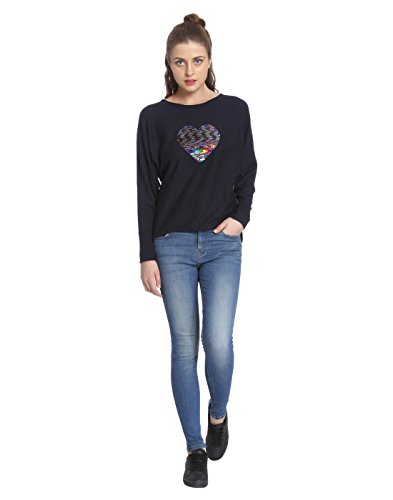

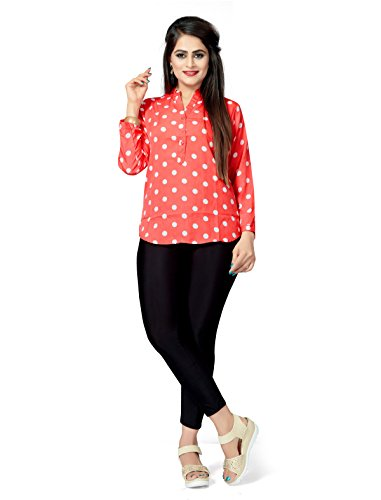

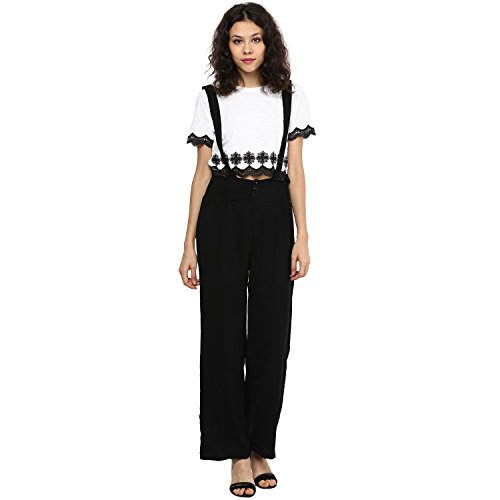

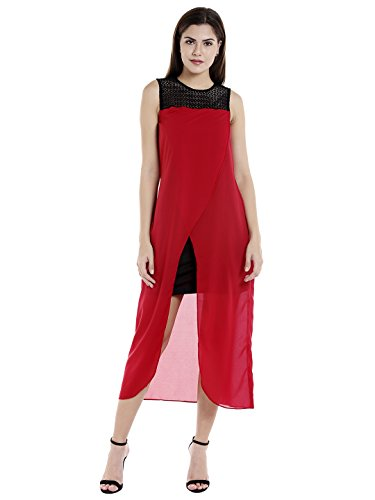


Input Product Details (ID: B083X4QH2Y):
Name: 
Rating: 3.3

Recommended Products:
Recommended 1 ID: B07NSC3QQL
Name: 1 stop fashion women s regular fit top
Rating: 3.0
----------------------------------------
Recommended 2 ID: B07FQRLQ45
Name: 109 f women black solid polyest jumpsuit without top
Rating: 3.7
----------------------------------------
Recommended 3 ID: B07FVQPKKN
Name: 109 f women polyest red solid maxi dress
Rating: 4.0
----------------------------------------

Model Accuracy:
Training MAE: 0.742926299571991
Validation MAE: 0.6572123765945435


In [95]:
import numpy as np
import pandas as pd
import requests
from io import BytesIO
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import Image as IPImage, display


# Preprocessing function to load and resize images
def preprocess_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((224, 224))  # Resize to MobileNet input size
    img = image.img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess image for MobileNet
    return img


# Prepare the data for training by extracting features from images
def extract_features(data):
    model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.trainable = False  # Freeze the pre-trained layers

    # Global Average Pooling layer to convert feature maps to 1D
    model = models.Sequential([
        model,
        layers.GlobalAveragePooling2D()
    ])
    
    features = []
    for img_url in data['medium']:  # Assuming 'medium' contains image URLs
        img = preprocess_image(img_url)
        feature = model.predict(img)
        features.append(feature.flatten())  # Flatten the features to a 1D array
    
    return np.array(features)


# Limit the dataset to the first 100 rows
data_limited = data.head(100)

# Extract features for the limited dataset
features_limited = extract_features(data_limited)

# Function to train the model with additional layers
def train_model(features, epochs=10):
    # Adding Dense and Dropout layers on top of MobileNetV2 features
    custom_model = models.Sequential([
        layers.InputLayer(input_shape=(features.shape[1],)),  # Input shape from the feature vector
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)  # Output layer for regression (rating prediction)
    ])

    # Compile the model
    custom_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model using the extracted features as input
    X_train, X_test, y_train, y_test = train_test_split(features, data_limited['rating'], test_size=0.2, random_state=42)

    # Fit the model to the training data
    history = custom_model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_test, y_test))

    return custom_model, history


# Train the model with 10 epochs on the limited dataset
custom_model, history = train_model(features_limited, epochs=10)


# Function to recommend similar products based on cosine similarity (using the limited data)
def recommend_similar_products_limited(product_id, top_n=3):
    # Find the index of the product based on product_id
    product_index = data_limited[data_limited['asin'] == product_id].index[0]
    
    # Get the feature vector of the input product
    input_feature = features_limited[product_index].reshape(1, -1)
    
    # Compute cosine similarity between the input product and all other products
    similarities = cosine_similarity(input_feature, features_limited)
    
    # Get indices of the top N most similar products (excluding the input product itself)
    similar_indices = similarities.argsort()[0][::-1][1:top_n+1]  # Ignore the first one (input product)
    
    # Display the input product's image using IPython
    input_img_url = data_limited.loc[product_index, 'medium']
    display(IPImage(input_img_url))
    
    # Display the recommended product images using IPython
    for i, index in enumerate(similar_indices):
        img_url = data_limited.loc[index, 'medium']
        display(IPImage(img_url))

    # Print product details and model accuracy
    print(f"\nInput Product Details (ID: {product_id}):")
    print(f"Name: {data_limited.loc[product_index, 'product_name']}")
    print(f"Rating: {data_limited.loc[product_index, 'rating']}")
    
    print("\nRecommended Products:")
    for i, index in enumerate(similar_indices):
        print(f"Recommended {i+1} ID: {data_limited.loc[index, 'asin']}")
        print(f"Name: {data_limited.loc[index, 'product_name']}")
        print(f"Rating: {data_limited.loc[index, 'rating']}")
        print('-' * 40)
    
    # Print model training/validation accuracy
    print("\nModel Accuracy:")
    print(f"Training MAE: {history.history['mae'][-1]}")
    print(f"Validation MAE: {history.history['val_mae'][-1]}")

# Example: Recommend 3 similar products to the product with ASIN 'B083X4QH2Y' from the limited dataset
recommend_similar_products_limited('B083X4QH2Y', top_n=3)


In [103]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, Image

# Function to compute textual similarity using TF-IDF
def compute_textual_similarity(query_text, product_names, brand_names):
    # Combine product name and brand name into one string for each product
    combined_text = [f"{product} {brand}" for product, brand in zip(product_names, brand_names)]
    
    # Use TF-IDF to transform the combined product and brand names into feature vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    
    # Transform the query text
    query_tfidf = vectorizer.transform([query_text])
    
    # Compute cosine similarity between query text and all products
    return cosine_similarity(query_tfidf, tfidf_matrix).flatten()

# Recommendation function based on product ID
def recommend_products_by_product_id(product_id, data, num_recommendations=5):
    """
    Recommend products based on the combination of product name and brand name similarity.
    """
    # Get the product row for the given ID
    product_row = data[data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return

    # Extract the product name and brand name for the given product ID
    train_product_name = product_row.iloc[0]['product_name']
    train_brand_name = product_row.iloc[0]['brand']
    train_text = f"{train_product_name} {train_brand_name}"
    print(f"Training with product: {train_text}")
    
    # Compute textual similarity between the given product and all other products in the dataset
    similarities = compute_textual_similarity(train_text, data['product_name'], data['brand'])

    # Add similarity scores to the dataset
    data['similarity'] = similarities
    
    # Rank the products by similarity score, excluding the target product
    recommendations = data[data['asin'] != product_id].sort_values(by='similarity', ascending=False).head(num_recommendations)
    
    # Display recommendations and respective images
    print(f"Top {num_recommendations} recommendations based on the similarity to product ID: {product_id}\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Brand Name: {row['brand']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        print("-" * 50)
        
        # Display product image
        display(Image(url=row['medium'], width=200, height=200))

# Example usage
recommend_products_by_product_id(product_id="B01DAYHAMI", data=data, num_recommendations=5)


Training with product: 100 solid silk purpl extra extra long tie 70inch extra long tie big tall men 14 solid color choos Longtiestore
Top 5 recommendations based on the similarity to product ID: B01DAYHAMI

Product ID: B01ASWB78I
Product Name: 100 silk extra extra long tie lavend herringbon silk xxl 70inch length
Brand Name: Longtiestore
Price: 590.0
Rating: 4.2
--------------------------------------------------


Product ID: B013HJFT6U
Product Name: 100 silk extra long solid black tie herringbon pattern 70 long
Brand Name: Longtiestore
Price: 590.0
Rating: 4.2
--------------------------------------------------


Product ID: B00JLGPP86
Product Name: 100 silk diamond pattern men s extra long tie avail 63 xl 70 xxl
Brand Name: Longtiestore
Price: 590.0
Rating: 4.6
--------------------------------------------------


Product ID: B013HNPK4M
Product Name: 100 silk extra long navi neckti polka dot 70 long
Brand Name: Longtiestore
Price: 590.0
Rating: 4.7
--------------------------------------------------


Product ID: B013HL6FL6
Product Name: 100 silk extra long tie diamond weav pattern avail 63 xl 70 xxl
Brand Name: Longtiestore
Price: 590.0
Rating: 4.5
--------------------------------------------------


In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, Image

# Function to compute textual similarity using TF-IDF
def compute_textual_similarity(query_text, product_names, brand_names):
    # Combine product name and brand name into one string for each product
    combined_text = [f"{product} {brand}" for product, brand in zip(product_names, brand_names)]
    
    # Use TF-IDF to transform the combined product and brand names into feature vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    
    # Transform the query text
    query_tfidf = vectorizer.transform([query_text])
    
    # Compute cosine similarity between query text and all products
    return cosine_similarity(query_tfidf, tfidf_matrix).flatten()

# Recommendation function based on product ID
def recommend_products_by_product_id(product_id, data, num_recommendations=5):
    """
    Recommend products based on the combination of product name and brand name similarity,
    strictly sorted by ascending order of rating.
    """
    # Get the product row for the given ID
    product_row = data[data['asin'] == product_id]
    if product_row.empty:
        print(f"Product with ID '{product_id}' not found in the dataset.")
        return

    # Extract the product name and brand name for the given product ID
    train_product_name = product_row.iloc[0]['product_name']
    train_brand_name = product_row.iloc[0]['brand']
    train_text = f"{train_product_name} {train_brand_name}"
    print(f"Training with product: {train_text}")
    
    # Compute textual similarity between the given product and all other products in the dataset
    similarities = compute_textual_similarity(train_text, data['product_name'], data['brand'])

    # Add similarity scores to the dataset
    data['similarity'] = similarities
    
    # Filter out the target product and sort by rating in ascending order
    recommendations = (
        data[data['asin'] != product_id]
        .sort_values(by=['rating', 'similarity'], ascending=[True, False])  # Sort by rating first, then similarity
        .head(num_recommendations)
    )
    
    # Display recommendations and respective images
    print(f"Top {num_recommendations} recommendations based on the similarity to product ID: {product_id}\n")
    for _, row in recommendations.iterrows():
        print(f"Product ID: {row['asin']}")
        print(f"Product Name: {row['product_name']}")
        print(f"Brand Name: {row['brand']}")
        print(f"Price: {row['sales_price']}")
        print(f"Rating: {row['rating']}")
        print("-" * 50)
        
        # Display product image
        display(Image(url=row['medium'], width=200, height=200))

# Example usage
recommend_products_by_product_id(product_id="B01DAYHAMI", data=data, num_recommendations=5)


Training with product: 100 solid silk purpl extra extra long tie 70inch extra long tie big tall men 14 solid color choos Longtiestore
Top 5 recommendations based on the similarity to product ID: B01DAYHAMI

Product ID: B07QFR3RFG
Product Name: ziyaa women s art silk alin kurta
Brand Name: ZIYAA
Price: 499.0
Rating: 1.4
--------------------------------------------------


Product ID: B07NTXHRPL
Product Name: shoe nation design vintag lastest men women adjust jean dad hat cotton basebal cap black
Brand Name: FFbbht
Price: 590.0
Rating: 1.4
--------------------------------------------------


Product ID: B07MCDF444
Product Name: cotton print white long boat neck kurti
Brand Name: Meher
Price: 549.0
Rating: 1.5
--------------------------------------------------


Product ID: B07WN1XD5T
Product Name: yaanvi women s rayon solid short topshort kurti
Brand Name: YAANVI
Price: 650.0
Rating: 1.5
--------------------------------------------------


Product ID: B07GKV6LKS
Product Name: navya export women s cotton bhagalpuri silk sare blous ne758 bandhani multi color free size
Brand Name: Navya Export
Price: 399.0
Rating: 1.5
--------------------------------------------------
